In [1]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
import random
from numpy import linalg as LA
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

C:\Users\Ruoxi\Anaconda\lib\site-packages\GPy\util\linalg.py:48: UserWarning: warning: caught this exception:function 'dsyrk_' not found
  warnings.warn("warning: caught this exception:" + str(e))


## Reference

Derivation below is based on the following reference: 
    
https://books.google.com/books?id=PQOYnT7P1loC&printsec=frontcover&source=gbs_ViewAPI#v=onepage&q&f=false
    
This reference defines matrix normal distribution using row-wise vectorization of matrix X, that is 

$\mathrm{vec}(\mathbf{X.T}) \sim \mathcal{N}_{pn}(\mathrm{vec}(\mathbf{M.T}), \mathbf{U} \otimes \mathbf{V})$
(Reference, Page 55, Definition 2.2.1), which is equivalent with column-wise vectorization $\mathrm{vec}(\mathbf{X}) \sim \mathcal{N}_{np}(\mathrm{vec}(\mathbf{M}), \mathbf{V} \otimes \mathbf{U})$
(The proof is Theorem 2.3.1, Page 56). 

For simplicity, we will use the latter notation (column-wise vectorization) in the rest of this report. 


## Description 

### Two dimensions 
Multivariate normal distribution $X \sim \mathcal{MN}_{N,P}(M,U,V)$, where expectation $M \in R^{n \times p}$, $U \in R^{n \times n}$, $V \in R^{p \times p}$. 

The probability density function is  

$p(\mathbf{X}\mid\mathbf{M}, \mathbf{U}, \mathbf{V}) = \frac{\exp\left( -\frac{1}{2} \, \mathrm{tr}\left[ \mathbf{V}^{-1} (\mathbf{X} - \mathbf{M})^{T} \mathbf{U}^{-1} (\mathbf{X} - \mathbf{M}) \right] \right)}{(2\pi)^{np/2} |\mathbf{V}|^{n/2} |\mathbf{U}|^{p/2}}$

where $\mathrm{vec}(\mathbf{X}) \sim \mathcal{N}_{np}(\mathrm{vec}(\mathbf{M}), \mathbf{V} \otimes \mathbf{U})$, where  $\mathrm{vec}()$ is column-wise vectorization. 
    
The equivalence between the above ''matrix normal'' and ''multivariate normal'' density functions (vectorize by column) can be shown: 


$-\frac{1}{2}\text{tr}\left[ \mathbf{V}^{-1} (\mathbf{X} - \mathbf{M})^{T} \mathbf{U}^{-1} (\mathbf{X} - \mathbf{M}) \right]\\$

$= -\frac{1}{2}\text{vec}\left(\mathbf{X} - \mathbf{M}\right)^T
\text{vec}\left(\mathbf{U}^{-1} (\mathbf{X} - \mathbf{M}) \mathbf{V}^{-1}\right) \\
$

$
=-\frac{1}{2}\text{vec}\left(\mathbf{X} - \mathbf{M}\right)^T
\left(\mathbf{V}^{-1}\otimes\mathbf{U}^{-1}\right)\text{vec}\left(\mathbf{X} - \mathbf{M}\right) \\
$

$= -\frac{1}{2}\left[\text{vec}(\mathbf{X}) - \text{vec}(\mathbf{M})\right]^T
\left(\mathbf{V}\otimes\mathbf{U}\right)^{-1}\left[\text{vec}(\mathbf{X}) - \text{vec}(\mathbf{M})\right] 
$

The covariance parameters are non-identifiable in the sense that for any scale factor, ''s>0'', we have:
$
\mathcal{MN}_{n\times p}(\mathbf{X}\mid\mathbf{M},\mathbf{U},\mathbf{V}) = \mathcal{MN}_{n\times p}(\mathbf{X}\mid\mathbf{M},s\mathbf{U},1/s\mathbf{V}) .
$




## Properties

$E[\mathbf{X}^{T}\mathbf{A}\mathbf{X}]
 = \mathbf{V}\operatorname{tr}(\mathbf{U}\mathbf{A^T})+ \mathbf{M^TAM}$.   $\qquad$ (1)

$E[\mathbf{X}\mathbf{A}\mathbf{X}^{T}]
 = \mathbf{U}\operatorname{tr}(\mathbf{A}^T\mathbf{V}) + \mathbf{MAM}^T$.   $\qquad$ (2)

The proof for (1)(2) is in reference, Page 60, Theorem 2.3.5 (i)(ii)
    
Let $\mathbf{A}$ to be identity matrix, then 

(1) When expectation $\mathbf{M}$ is $\mathbf{0_{n \times p}}$, we use (1)(2) and get

$ E[\mathbf{X^T} \mathbf{X}]
= \mathbf{V}\operatorname{tr}(\mathbf{U}) $ $\qquad$ (3)
 
$E[\mathbf{X} \mathbf{X^T}]
= \mathbf{U}\operatorname{tr}(\mathbf{V}) $ $\qquad$(4)

(2) When expectation $\mathbf{M}$ is not $\mathbf{0_{n \times p}}$, we substruct expectation first, and use (3)(4), we get,

$E[(\mathbf{X} - \mathbf{M})^T(\mathbf{X} - \mathbf{M})] = \mathbf{V}\operatorname{tr}(\mathbf{U})$  $\qquad$ (5)

$E[(\mathbf{X} - \mathbf{M})(\mathbf{X} - \mathbf{M})^{T}] = \mathbf{U}\operatorname{tr}(\mathbf{V})$  $\qquad$ (6)



(3) (4) is a specific case of (5)(6). Therefore (5)(6) hold for any expectation $\mathbf{M}$



## We were discussing about 

$E[(\mathbf{X} - \mathbf{M})(\mathbf{X} - \mathbf{M})^{T}]
= \mathbf{U}\operatorname{tr}(\mathbf{V}) $, where $\mathbf{X} \in \mathbf{R^{p \times n}}$

We reached the conclusion that the left hand side is covariance of $\mathbf{X}$, which can be calculated using python function "np.cov()"

I agree with the above statement when $\mathbf{X}$ is a vector, but here $\mathbf{X}$ is a matrix. The left hand side is the expectation of outerproduct of the two matrixes, instead of sample covariance calculated by np.cov() .  Specifically, 
$E[(\mathbf{X} - \mathbf{M})(\mathbf{X} - \mathbf{M})^{T}]= \mathbf{U}\operatorname{tr}(\mathbf{V}) \approx np.cov(\mathbf{X})\times (n-1) $, where n-1 is normalization factor of np.cov() 

To confirm this, we will first show what is "np.cov($\mathbf{X}$)" calculating, then performing a small experiment to show $\mathbf{U}\operatorname{tr}(\mathbf{V}) \approx np.cov(\mathbf{X})\times (n-1)$. 



 

## np.cov($X$)

Function "$\mathbf{np.cov(X)}$" is to calculate sample covariance of $\mathbf{p}$ dimension vector using $\mathbf{n}$ samples, where $\mathbf{X \in R^{p \times n}}$
    
We assume $\mathbf{X}$  stacks $\mathbf{n}$  samples and each sample is a $\mathbf{p}$  dimension vector. So $\mathbf{np.cov(x)}$ is first substracting each element by its row
mean (sample mean), the resulting matrix is denoted as $\mathbf{Xnew}$, then calculating $\mathbf{XnewXnew^T/(n-1)}$

To confirm what we described here, please see: 


In [6]:
# test above
X = np.random.rand(10,20) # random matrix 10-by-20

# use np.cov()
out1 = np.cov(X)

# calculate as described above 
x_mean = np.mean(np.matrix(X), axis=1) # mean of rows
x_new = X - np.repeat(x_mean,X.shape[1], axis=1) # substract mean of rows
out2 = x_new * x_new.T/(X.shape[1]-1) # normalize 

# confirm out1==out2
out1-out2



matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## The experiment

We performed an experiment below to draw "Ndraw" samples and calculate 

(1) out1 = mean of $\mathbf{np.cov(x)}$ 

(2) out2 = mean of the outer product, $\mathbf{XX^T}$

(3) out3 = mean of $\mathbf{np.cov(x) \times (n-1)}$

We compare out1, out2, out3 with the expeced value $\mathbf{U}\operatorname{tr}(\mathbf{V})$

We observe that out2 is most close to the expected value, then out3. but out1 is not close to expected value

out2 is more accurate than out3. The reason is when calculating $E[(\mathbf{X} - \mathbf{M})(\mathbf{X} - \mathbf{M})^{T}] $, out2 is substracting the real expecation $\mathbf{M} = 0$
from $\mathbf{X}$, whereas out3 is substracting sample mean (row mean). Sample mean can be values other than $\mathbf{0}$. Therefore, $\mathbf{XX^T}$ is more accurate.

Because of the same reason, we propose to calculate outer product by mean of $\mathbf{XX^T}$, instead of  $\mathbf{np.cov(x)\times (n-1)}$. 
 
** In the rest of this report, we denote $\mathbf{E(XX^T)}$ as mean of the outer product of $\mathbf{X}$ **

In [7]:
# randomly generate U and V
t = np.arange(0,20,1)[np.newaxis].transpose()
n = np.arange(0,10,1)[np.newaxis].transpose()
k1 = gpy.kern.RBF(1) 
V = k1.K(t) 
k2 = gpy.kern.RBF(1, variance=2)
U = k2.K(n)
# M is zero
M = np.matrix(np.zeros((n.size,t.size)))
 

npcov_sum = 0
OuterProduct_sum = 0
Ndraw = 10000

for i in xrange(1, Ndraw):
    # generate sample
    x = np.random.multivariate_normal(np.zeros(t.size*n.size), np.kron(V,U), 1).reshape(t.size,n.size).T
    npcov_sum = npcov_sum + np.cov(x)
    OuterProduct_sum = OuterProduct_sum + np.dot(x, x.T)
    
npcov_results_mean = npcov_sum/Ndraw
OuterProduct_results_mean = OuterProduct_sum/Ndraw

<matplotlib.colorbar.Colorbar instance at 0x0000000013028E88>

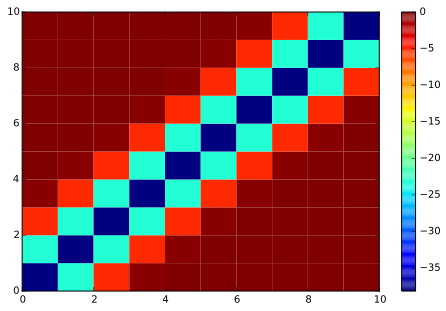

In [8]:
# compare "np.cov(X)" with U*tr(V) 
out1 = npcov_results_mean - U * np.trace(V)
#print out1

# plot the difference 
out1 = np.squeeze(np.asarray(out1))
plt.pcolor(out1)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x000000001A285588>

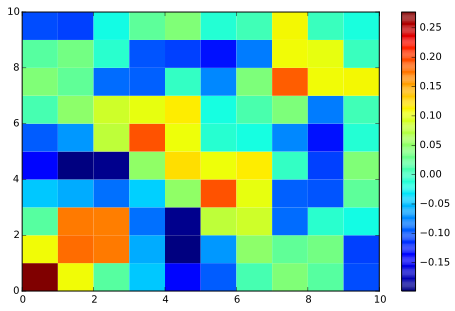

In [9]:
# compare "outer product X*X^T" with U*tr(V) 
out2 = OuterProduct_results_mean - U * np.trace(V)
#print out2

# plot the difference 
out2 = np.squeeze(np.asarray(out2))
plt.pcolor(out2)
plt.colorbar() 

<matplotlib.colorbar.Colorbar instance at 0x000000001A562088>

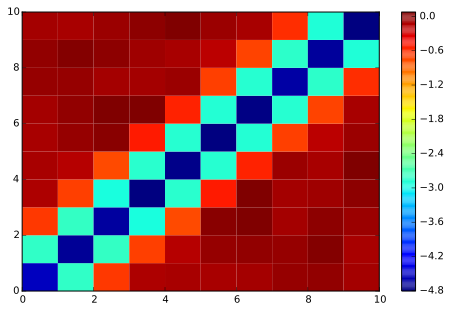

In [10]:
# compare "np.cov(X)×(n−1)" with U*tr(V) 
out3 = npcov_results_mean * (x.shape[1]-1) - U * np.trace(V)
#print out3

# plot the difference 
out3 = np.squeeze(np.asarray(out3))
plt.pcolor(out3)
plt.colorbar() 

## Infer U and V

We use (3)(4)

$ E[\mathbf{X^T} \mathbf{X}]
= \mathbf{V}\operatorname{tr}(\mathbf{U}) $ $\qquad$  (3)
 
$E[\mathbf{X} \mathbf{X^T}]
= \mathbf{U}\operatorname{tr}(\mathbf{V}) $ $\qquad$  (4)



Take trace of both sides, 

$\mathbf{\operatorname{tr}}(E[\mathbf{X^T} \mathbf{X}]) =\mathbf{\operatorname{tr}}(E[\mathbf{X} \mathbf{X^T}])= \mathbf{\operatorname{tr}}(\mathbf{V})\operatorname{tr}(\mathbf{U})$
 $\qquad$ (7)

From (3)

V = $E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(U)$  $\qquad$ (8)

Plug (8) ino (4)

$E[\mathbf{X} \mathbf{X^T}] = \mathbf{U}\operatorname{tr}(\mathbf{E[\mathbf{X^T} \mathbf{X}])/\operatorname{tr}(U)}$  $\qquad$ (9)

$E[\mathbf{X} \mathbf{X^T}]/\operatorname{tr}(E[\mathbf{X^T} \mathbf{X}]) =E[\mathbf{X} \mathbf{X^T}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])= \mathbf{U}\operatorname{tr}(\mathbf{U})$ $\qquad$ (10)
                                                          
Similarly, 
                                                          
$E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}]) = E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(E[\mathbf{X^T} \mathbf{X}]) =\mathbf{V}\operatorname{tr}(\mathbf{V})$ $\qquad$ (11)                                                          
 
From (10)(11)(8)
   

U =$\operatorname{tr}(U) \times E[\mathbf{X} \mathbf{X^T}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$     $\qquad$ (12) 

V =$\operatorname{tr}(V) \times E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$     $\qquad$ (13) 


Let  

$\mathbf{\operatorname{tr}(U)}$ = k1

$\mathbf{\operatorname{tr}(V)}$ = k2
    
Therefore, 

U = k1 * $E[\mathbf{X} \mathbf{X^T}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$

V = k2 * $E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$

$\mathbf{s.t.} $  $k1 * k2$= $\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$

Therefore, U and V are non-identifiable. In other words, there are many solution pairs for U and V. 

As long as three conditions are satisfied, 

(1) U is a scaled version of $E[\mathbf{X} \mathbf{X^T}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$

(2) V is a scaled version of  $E[\mathbf{X^T} \mathbf{X}]/\operatorname{tr}(E[\mathbf{X} \mathbf{X^T}])$

(3) $\mathbf{\operatorname{tr}}(\mathbf{V})\operatorname{tr}(\mathbf{U}) = \mathbf{\operatorname{tr}}(E[\mathbf{X^T} \mathbf{X}])$
  
where $E[\mathbf{X} \mathbf{X^T}]$ is outer product of $X$

## Three dimensions

 

$\mathbf{X} \sim N(0, W \otimes U \otimes V)$, where $U \in R^{n \times n}$, $V \in R^{t \times t}$, $W \in R^{c \times c}$
            
$\mathbf{X} \in R^{n \times t \times c}$
        
$\mathbf{X_N} = R^{n \times tc}$, flatten t,c axises 

$\mathbf{X_T} = R^{t \times nc}$, flatten n,c axises 

$\mathbf{X_C} = R^{c \times nt}$, flatten t,n axises 



Let $foo = W \otimes U$, then $X \sim N(0, foo \otimes V)$

From two dimensions case, we have

$ E[ X_T^T X_T ]
= V\operatorname{tr}(foo) $    

$ \operatorname{tr}(E[ X_T^T X_T ])
= \operatorname{tr}(V) \operatorname{tr}(foo) = \operatorname{tr}(V) \operatorname{tr}(U) \operatorname{tr}(W) $   $\qquad$ (14)

So

$V = \operatorname{tr}(V) \times E[ X_TX_T^T ]/\operatorname{tr}(E[ X_TX_T^T])$      $\qquad$ (15)


Similarly, 

$U = \operatorname{tr}(U) \times E[ X_UX_U^T ]/\operatorname{tr}(E[ X_UX_U^T])$  $\qquad$ (16)

$W = \operatorname{tr}(W) \times E[ X_CX_C^T ]/\operatorname{tr}(E[ X_CX_C^T])$  $\qquad$ (17)

 
Like two dimension case, 

$\mathbf{U}, \mathbf{V}, \mathbf{W}$ are non-identifiable. In other words, there are many solution triplets for U, V, W. 

As long as four conditions are satisfied, 

(1) U is a scaled version of $E[\mathbf{X_N} \mathbf{X_N^T}]/\operatorname{tr}(E[\mathbf{X_N} \mathbf{X_N^T}])$, scale factor is $\operatorname{tr}(U)$

(2) V is a scaled version of  $E[\mathbf{X_T} \mathbf{X_T^T}]/\operatorname{tr}(E[\mathbf{X_T} \mathbf{X_T^T}])$, scale factor is $\operatorname{tr}(V)$

(3) W  is a scaled version of $E[\mathbf{X_C} \mathbf{X_C^T}]/\operatorname{tr}(E[\mathbf{X_C} \mathbf{X_C^T}])$, scale factor is $\operatorname{tr}(W)$

(4) $\mathbf{\operatorname{tr}}(\mathbf{V})\operatorname{tr}(\mathbf{U}) \mathbf{\operatorname{tr}}(\mathbf{W})=  \mathbf{\operatorname{tr}}(E[\mathbf{X_T^T} \mathbf{X_T}]) = \mathbf{\operatorname{tr}}(E[\mathbf{X_N^T} \mathbf{X_N}]) = \mathbf{\operatorname{tr}}(E[\mathbf{X_C^T} \mathbf{X_C}])$
  
where $E[\mathbf{X} \mathbf{X^T}]$ is the outer product of $\mathbf{X}$



## Generate data

We are given covariance matrices along N,T,C, which are cov_N, cov_T, cov_C. We will use the three covariance matrices to infer U,V,W
. Then we will calculate covariance matrices along the three axis of samples drawn using inferred U,V,W to confirm that we recover the ground truth
cov_N, cov_T, cov_C

In [2]:
# number of samples
n = np.arange(0,5,1)[np.newaxis].transpose() 

# time
fs = 5.0  #  time step:1/fs
t = np.arange(0,5,1/fs)[np.newaxis].transpose()
t.size

# number of cancer types
c = np.arange(0,6,1)[np.newaxis].transpose() 
c.size

6

In [3]:
# Given covariance matrix 
# Requirement: tr(OuterProduct_N) = tr(OuterProduct_T) = tr(OuterProduct_C)

# OuterProduct_N: along N
k1 = gpy.kern.RBF(1, variance=0.2, lengthscale=1)
cov_N = k1.K(n) #given covariance, ground truth
OuterProduct_N = cov_N * float(t.size * c.size-1)
print np.matrix.trace(OuterProduct_N)

# OuterProduct_T: along T
k2 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(t.size*float(n.size*c.size-1)), lengthscale=2)
cov_T = k2.K(t) #given covariance, ground truth
OuterProduct_T = cov_T * float(n.size*c.size-1)
print np.matrix.trace(OuterProduct_T)

# OuterProduct_C: along C
k3 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(c.size*float(t.size*n.size-1)), lengthscale=1)
cov_C = k3.K(c) #given covariance, ground truth
OuterProduct_C = cov_C * float(t.size*n.size-1)
print np.matrix.trace(OuterProduct_C)

149.0
149.0
149.0


In [4]:
# Infer U,V,W

# random generate positive scale factors, the product of the three has to be equal to trace of the outer product
# the range is arbitrary

k1 = random.uniform(2, np.matrix.trace(OuterProduct_N)** 0.5) 
k2 = random.uniform(2, np.matrix.trace(OuterProduct_N)** 0.5)
k3 = np.matrix.trace(OuterProduct_N)/(k1*k2)

#k1 = np.matrix.trace(OuterProduct_N) 
#k2 = 1
#k3 = 1

U = OuterProduct_N/np.matrix.trace(OuterProduct_N) * k1
V = OuterProduct_T/np.matrix.trace(OuterProduct_T) * k2
W = OuterProduct_C/np.matrix.trace(OuterProduct_C) * k3

In [5]:
print k1
print k2
print k3

6.99102994496
8.06110023219
2.64393506585


## Sampling 

$Z \sim N(0,I_{NTC})$

$Z \in R^{NTC}$

$X = LZ \sim N(0,\Sigma)$, where $\Sigma = QVQ^T$

$L = QV^{1/2}$

$X = QV^{1/2}Z \sim  N(0,\Sigma)$

## Eigen-decomposition
For kernels, $K = K^1 \otimes K^2 \otimes K^3 ... \otimes K^P$, where each $K^P = Q^PV^PQ^T$

$K = QVQ^T$

$V = V^1 \otimes V^2 \otimes V^3 ... \otimes V^P$

$Q = Q^1 \otimes Q^2 \otimes Q^3 ... \otimes Q^P$

 ## GP-grid trick

$X = (Q_1 \otimes Q_2 \otimes Q_3 ... \otimes Q_P)( V_1^{1/2} \otimes V_2^{1/2} \otimes V_3^{1/2} ... \otimes V_P^{1/2})Z$

## kron_mvprod(As,b) 
Gilboa et al, $(\bigotimes_{d=1}^DA_d)b = vec([A_1 ...[A_{D-1}[A_DB]^T]^T]^T)$, where b is a vector

Here we implement "Algorithm 2" in Gilboa et al with minor modifications. 
We make b a matrix, whose columns are different samples,  so that we are able to draw thousands of samples simutanously. 


In [6]:
def kron_mvprod2(As,b):
    x = b
    for d in np.arange(len(As)-1,-1,-1):
        Gd = As[d].shape[0]
        N = x.size
        X = np.matrix(x.reshape(Gd,N/Gd,order='F'))
        Z = As[d]*X
        Z = Z.T
        x = Z.reshape(Z.size/b.shape[1],b.shape[1],order='F') 
       
    out = x.reshape(1,x.size,order='F') 
    out = out.reshape(x.size/b.shape[1],b.shape[1],order='C') 
    return out;

In [7]:
# test kron_mvprod2
A1 =  np.matrix([[1, 2], [3, 4]])
A2 =  np.matrix([[5,6,7], [8,9,10],[11,12,13]])
A3 =  np.matrix([[5,2], [6,4]])
As = [A1,A2,A3]
b = np.random.random((12,3))*10

# confirm kron_mvprod2
out1 =  kron_mvprod2(As,b)
out2 = np.kron(A1,np.kron(A2,A3)) * np.matrix(b) 
out1-out2 #close to zero

matrix([[  2.27373675e-13,  -2.27373675e-13,   2.27373675e-13],
        [  0.00000000e+00,  -4.54747351e-13,   4.54747351e-13],
        [  0.00000000e+00,   4.54747351e-13,   0.00000000e+00],
        [ -9.09494702e-13,   0.00000000e+00,  -4.54747351e-13],
        [  0.00000000e+00,  -4.54747351e-13,   0.00000000e+00],
        [  9.09494702e-13,  -9.09494702e-13,   0.00000000e+00],
        [  0.00000000e+00,  -4.54747351e-13,   4.54747351e-13],
        [  0.00000000e+00,   9.09494702e-13,   0.00000000e+00],
        [  0.00000000e+00,   9.09494702e-13,   9.09494702e-13],
        [ -1.81898940e-12,   1.81898940e-12,   0.00000000e+00],
        [ -1.81898940e-12,   0.00000000e+00,  -9.09494702e-13],
        [  1.81898940e-12,   0.00000000e+00,   0.00000000e+00]])

In [14]:
V1, Q1 = LA.eig(W)
V2, Q2 = LA.eig(U.T)
V3, Q3 = LA.eig(V.T)

V1 = np.diag(V1)
V2 = np.diag(V2)
V3 = np.diag(V3)


V1_half = np.lib.scimath.sqrt(V1)
V2_half = np.lib.scimath.sqrt(V2)
V3_half = np.lib.scimath.sqrt(V3)


# Generate Ndraw samples
dimension = t.size*n.size*c.size
Ndraws = 5000
Z = np.random.normal(size=Ndraws*dimension).reshape(dimension, Ndraws)
X = kron_mvprod2([Q1,Q2,Q3],kron_mvprod2([V1_half,V2_half,V3_half],Z)).real

## Estimate covariance from data

Estimated covariane (Covariance_N_estimation) of ground truth (con_N) is calculated by mean of $\mathbf{X_N} \mathbf{X_N^T}/(t.size*c.size-1)$ using Ndraw samples

In [15]:
Covariance_N_accumulation = 0  
Covariance_T_accumulation = 0  
Covariance_C_accumulation = 0  

# record error history: sum of absolute difference of every element
errorN_sum = [None] * Ndraws
errorT_sum = [None] * Ndraws
errorC_sum = [None] * Ndraws

# record error history: max difference 
errorN_max = [None] * Ndraws
errorT_max = [None] * Ndraws
errorC_max = [None] * Ndraws



for ndr in xrange(0, Ndraws):
     
    OneSample = np.array(X[:,ndr])
    # reshape
    OneSample_reshaped = OneSample.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along C
    OuterProduct_C = np.empty((c.size,c.size))
    
    # outer product: X_C*X_C^T
    for i in range(c.size):
        for j in range(c.size):
             OuterProduct_C[i,j] = (OneSample_reshaped[i,:,:] * OneSample_reshaped[j,:,:]).sum()
                
    Covariance_C_accumulation = Covariance_C_accumulation +  OuterProduct_C/(t.size*n.size-1)
    errorC_sum[ndr] = sum(sum(np.absolute(cov_C - Covariance_C_accumulation/(ndr+1))))
    errorC_max[ndr] = np.max(cov_C - Covariance_C_accumulation/(ndr+1)) 
   
    
    # covariance along N
    OuterProduct_N = np.empty((n.size,n.size))
    
    # outer product: X_N*X_N^T
    for i in range(n.size):
        for j in range(n.size):
            OuterProduct_N[i,j] = (OneSample_reshaped[:,i,:] * OneSample_reshaped[:,j,:]).sum()
    
    Covariance_N_accumulation = Covariance_N_accumulation + OuterProduct_N/(c.size*t.size-1)
    errorN_sum[ndr] = sum(sum(np.absolute(cov_N - Covariance_N_accumulation/(ndr+1))))
    errorN_max[ndr] = np.max(cov_N - Covariance_N_accumulation/(ndr+1)) 
    
    
    
    # covariance along T
    OuterProduct_T = np.empty((t.size,t.size))
    
    # outer product: X_T*X_T^T
    for i in range(t.size):
        for j in range(t.size):
            OuterProduct_T[i,j] = (OneSample_reshaped[:,:,i] * OneSample_reshaped[:,:,j]).sum() 
   
    Covariance_T_accumulation = Covariance_T_accumulation + OuterProduct_T/np.float(c.size*n.size-1)
    errorT_sum[ndr] = sum(sum(np.absolute(cov_T - Covariance_T_accumulation/(ndr+1))))
    errorT_max[ndr] = np.max(cov_T - Covariance_T_accumulation/(ndr+1)) 
    

Covariance_N_estimation = Covariance_N_accumulation/Ndraws
Covariance_T_estimation = Covariance_T_accumulation/Ndraws
Covariance_C_estimation = Covariance_C_accumulation/Ndraws
     

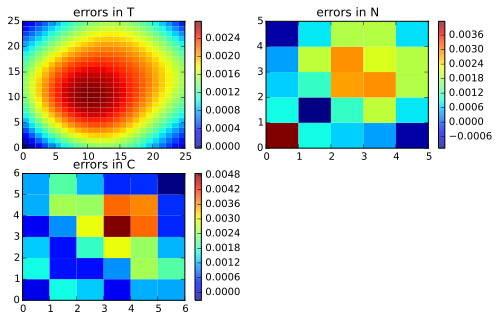

In [16]:
#plot difference between estimate "Covariance_T_estimation" and ground truth "cov_T"

plt.subplot(2, 2, 1)
# caovariance in T
data = cov_T - Covariance_T_estimation
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in T')

plt.subplot(2, 2, 2)
# caovariance in N
data = cov_N - Covariance_N_estimation
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in N') 

plt.subplot(2, 2, 3)
# covariance in C
data = cov_C - Covariance_C_estimation
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in C') 

plt.show()

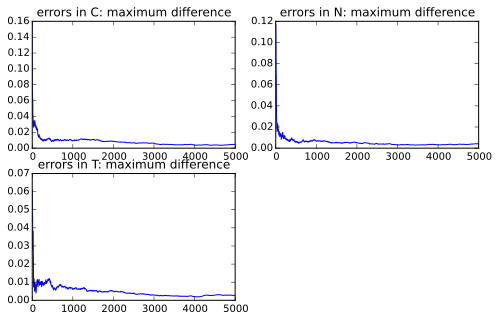

In [17]:
# error plot: maximum difference
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, Ndraws, Ndraws),np.abs(errorC_max))
plt.title('errors in C: maximum difference')
plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, Ndraws, Ndraws),np.abs(errorN_max))
plt.title('errors in N: maximum difference')
plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, Ndraws,Ndraws),np.abs(errorT_max))
plt.title('errors in T: maximum difference')

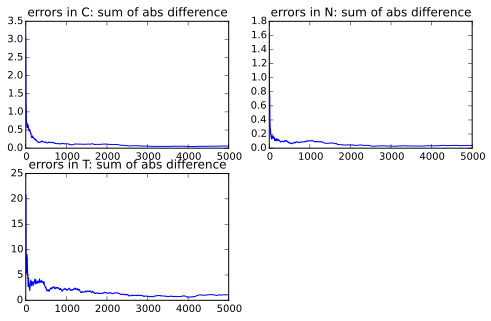

In [18]:
# error plot: sum of abs difference
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, Ndraws, Ndraws),np.abs(errorC_sum))
plt.title('errors in C: sum of abs difference')
plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, Ndraws, Ndraws),np.abs(errorN_sum))
plt.title('errors in N: sum of abs difference')
plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, Ndraws,Ndraws),np.abs(errorT_sum))
plt.title('errors in T: sum of abs difference')